In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **Data Processing:**

The data comes from Johns Hopkins (https://github.com/CSSEGISandData/COVID-19), which provides information on cumulative COVID-19 related deaths, and is already preprocessed to show daily values.

In [2]:
covid_df = pd.read_csv("./data_global_data.csv")
covid_df.tail()

,country,date,deaths,daily_deaths
218281,Zimbabwe,01/08/23,5637,0.0
218282,Zimbabwe,01/09/23,5637,0.0
218283,Zimbabwe,01/10/23,5637,0.0
218284,Zimbabwe,01/11/23,5637,0.0
218285,Zimbabwe,01/12/23,5637,0.0


In [3]:
covid_df.loc[covid_df['country'] == 'Brazil'] ## Check the indices for which we have Brazil entries

,country,date,deaths,daily_deaths
26064,Brazil,01/23/20,0,0.0
26065,Brazil,01/24/20,0,0.0
26066,Brazil,01/25/20,0,0.0
26067,Brazil,01/26/20,0,0.0
26068,Brazil,01/27/20,0,0.0
...,...,...,...,...
27145,Brazil,01/08/23,694779,0.0
27146,Brazil,01/09/23,694779,0.0
27147,Brazil,01/10/23,694985,206.0
27148,Brazil,01/11/23,695088,103.0


In [4]:
covid_df['date'] = pd.to_datetime(covid_df['date']) ## Converting the dates into a datetime object in Pandas
covid_df.loc[26064:27149]

C:\Users\luis_\AppData\Local\Temp\ipykernel_27456\1957043826.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  covid_df['date'] = pd.to_datetime(covid_df['date']) ## Converting the dates into a datetime object in Pandas


,country,date,deaths,daily_deaths
26064,Brazil,2020-01-23,0,0.0
26065,Brazil,2020-01-24,0,0.0
26066,Brazil,2020-01-25,0,0.0
26067,Brazil,2020-01-26,0,0.0
26068,Brazil,2020-01-27,0,0.0
...,...,...,...,...
27145,Brazil,2023-01-08,694779,0.0
27146,Brazil,2023-01-09,694779,0.0
27147,Brazil,2023-01-10,694985,206.0
27148,Brazil,2023-01-11,695088,103.0


## **Outline**
We'll process this data in three steps:

1. Define time steps for the pre-intervention and post-intervention period
2. Assign mobility interventions for each country
3. Reshape the data into a matrix form


## **Defining Time Steps**

Most epidemiological models suggest that, at the beginning of an epidemic process when the number of infected is far less than the population size, the dynamics of infection don't depend much on the population size itself. 

In this sense, we establish the time stamps of the data relative to the point at which 80 cumulative deaths are observed for every country. That is, the timestamp for the first date after which there are 80 cumulative deaths is 0. 

Then, we define timestamps -20 to -1 as a "pre-intervention" period and timestamps 0 to 20 as a "post-intervention" period.

In [5]:
## Define the number of deaths that will be used to define the pre-intervention period
pre_intervention_death_count = 80 

## Create a column to identify the post-intervention period
covid_df['post-intervention'] = covid_df['deaths'] >= pre_intervention_death_count 

covid_df.head()

,country,date,deaths,daily_deaths,post-intervention
0,Afghanistan,2020-01-23,0,0.0,False
1,Afghanistan,2020-01-24,0,0.0,False
2,Afghanistan,2020-01-25,0,0.0,False
3,Afghanistan,2020-01-26,0,0.0,False
4,Afghanistan,2020-01-27,0,0.0,False


In [6]:
# Get post-intervention date for each country
t0_date = covid_df[covid_df['post-intervention']].groupby('country')['date'].min()
t0_date

country
Afghanistan          2020-05-06
Albania              2020-07-07
Algeria              2020-04-02
Andorra              2020-12-18
Angola               2020-08-11
                        ...    
Vietnam              2021-06-29
West Bank and Gaza   2020-07-29
Yemen                2020-05-31
Zambia               2020-07-17
Zimbabwe             2020-08-03
Name: date, Length: 179, dtype: datetime64[ns]

In [7]:
# Create a column with the t0 date for each country
covid_df = pd.merge(covid_df, t0_date.reset_index(), on='country', how='left')\
                .rename(columns={'date_x': 'date', 'date_y': 't0_date'})

# Extract the difference between the date of the current observation and the t = 0 date
covid_df['t'] = (covid_df['date'] - covid_df['t0_date']).dt.days


In [8]:
# Filter the dates on where t is between -20 and 20
covid_df = covid_df[(covid_df['t'] >= -20) & (covid_df['t'] <= 20)]

covid_df.head()

,country,date,deaths,daily_deaths,post-intervention,t0_date,t
84,Afghanistan,2020-04-16,29,4.0,False,2020-05-06,-20.0
85,Afghanistan,2020-04-17,30,1.0,False,2020-05-06,-19.0
86,Afghanistan,2020-04-18,30,0.0,False,2020-05-06,-18.0
87,Afghanistan,2020-04-19,30,0.0,False,2020-05-06,-17.0
88,Afghanistan,2020-04-20,33,3.0,False,2020-05-06,-16.0


## **Assigning Mobility Interventions**

Here we'll assign mobility interventions for each country by using Google mobility data (https://www.google.com/covid19/mobility/). The Google data is reported relative to pre-2020 mobility, such that a score of -10 means that on that date, the mobility of a country's population is 10% less than pre-2020 levels. 

Then, we bucket countries as having three possible interventions:

| Intervention Type     | Reduction in Mobility (Compared to Jan. 2020 Baseline) |
|:----       |    :----:   | 
| Low    | <10%       |
| Moderate   | 10-40%        |
| Severe  | >40%        |

    
We'll measure the mobility reduction in the time period between $t = -20$ to $t = -1$, as we anticipate a delay between mobility reductions and reported case counts. Hence, we assume that it takes about 20 days for a reduction in mobility to impact future case counts.

In [9]:
mobility_df = pd.read_csv("./data_global_mobility_report.csv").rename(columns={'country_region': 'country'})

In [10]:
mobility_df[mobility_df['country'] == 'Brazil'] ## Find the indices for Brazil

,country_region_code,country,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
17436,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-15,5.0,4.0,-5.0,8.0,6.0,0.0
17437,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-16,2.0,3.0,-13.0,3.0,0.0,1.0
17438,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-17,-2.0,0.0,-12.0,9.0,19.0,-1.0
17439,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-18,-3.0,-1.0,-11.0,9.0,15.0,-1.0
17440,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-19,-1.0,-2.0,-5.0,8.0,14.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18405,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2022-10-11,16.0,62.0,16.0,11.0,33.0,0.0
18406,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2022-10-12,0.0,33.0,64.0,-35.0,-52.0,14.0
18407,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2022-10-13,4.0,55.0,24.0,8.0,34.0,1.0
18408,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2022-10-14,6.0,56.0,17.0,8.0,35.0,2.0


Here we focus on data from retail and recreation, since one of our main concerns here is how shutting down the economy affects COVID-19 fatalities.

In [11]:
mobility_df = pd.read_csv("./data_global_mobility_report.csv").rename(columns={'country_region': 'country'})
# restrict only to country wide data
mobility_df = mobility_df[mobility_df['sub_region_1'].isnull() & \
                          mobility_df['sub_region_2'].isnull() & \
                          mobility_df['metro_area'].isnull()]

mobility_df['date'] = pd.to_datetime(mobility_df['date']) ## Convert the dates into datetime objects
mobility_df[mobility_df['country'] == 'Brazil'][['country', 'date', 'retail_and_recreation_percent_change_from_baseline']] ## looking at retail and recreation percent change for Brazil

,country,date,retail_and_recreation_percent_change_from_baseline
17436,Brazil,2020-02-15,5.0
17437,Brazil,2020-02-16,2.0
17438,Brazil,2020-02-17,-2.0
17439,Brazil,2020-02-18,-3.0
17440,Brazil,2020-02-19,-1.0
...,...,...,...
18405,Brazil,2022-10-11,16.0
18406,Brazil,2022-10-12,0.0
18407,Brazil,2022-10-13,4.0
18408,Brazil,2022-10-14,6.0


In [12]:
# get mobility scores specifically on the dates that are reported in the covid_df when t is between -20 and -1
mobility_df = pd.merge(mobility_df, covid_df[covid_df['t'] < 0], on=['country', 'date'], how='right')

# now the retail scores are only on the dates we care about for each country
mobility_df[['country', 'date', 't', 'retail_and_recreation_percent_change_from_baseline']].head()

,country,date,t,retail_and_recreation_percent_change_from_baseline
0,Afghanistan,2020-04-16,-20.0,-46.0
1,Afghanistan,2020-04-17,-19.0,-41.0
2,Afghanistan,2020-04-18,-18.0,-43.0
3,Afghanistan,2020-04-19,-17.0,-43.0
4,Afghanistan,2020-04-20,-16.0,-42.0


In [13]:
# now we group countries based on their scores
country_mobility_scores = \
        mobility_df.groupby('country')['retail_and_recreation_percent_change_from_baseline'].mean()

low_countries = []
moderate_countries = []
severe_countries = []

for country, score in country_mobility_scores.items():
    if(not pd.isnull(score)):
        if(score > -10):
            low_countries.append(country)
        elif(score < -40):
            severe_countries.append(country)
        else:
            moderate_countries.append(country)

In [14]:
# Check the number of countries in each group
len(low_countries), len(moderate_countries), len(severe_countries)

(22, 50, 50)

In [15]:
# Checking Brazil's mobility score
brazil_score = country_mobility_scores.get('Brazil', None)
brazil_score


-26.9

## **Reshaping the Data**

The last step will be to get the dataset into a nice matrix form in order of running synthetic interventions

In [16]:
covid_df.head()

,country,date,deaths,daily_deaths,post-intervention,t0_date,t
84,Afghanistan,2020-04-16,29,4.0,False,2020-05-06,-20.0
85,Afghanistan,2020-04-17,30,1.0,False,2020-05-06,-19.0
86,Afghanistan,2020-04-18,30,0.0,False,2020-05-06,-18.0
87,Afghanistan,2020-04-19,30,0.0,False,2020-05-06,-17.0
88,Afghanistan,2020-04-20,33,3.0,False,2020-05-06,-16.0


In [17]:
covid_df = covid_df[['country', 'daily_deaths', 't']]\
        .pivot(index='country', columns='t', values='daily_deaths').reset_index()

covid_df.head()

t,country,-20.0,-19.0,-18.0,-17.0,-16.0,-15.0,-14.0,-13.0,-12.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
0,Afghanistan,4.0,1.0,0.0,0.0,3.0,3.0,0.0,4.0,0.0,...,1.0,4.0,4.0,10.0,6.0,12.0,10.0,7.0,1.0,1.0
1,Albania,1.0,1.0,3.0,1.0,1.0,0.0,1.0,2.0,2.0,...,4.0,1.0,1.0,4.0,3.0,3.0,5.0,6.0,4.0,6.0
2,Algeria,1.0,1.0,1.0,0.0,0.0,3.0,2.0,2.0,4.0,...,20.0,13.0,10.0,12.0,16.0,3.0,8.0,9.0,8.0,10.0
3,Andorra,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Angola,3.0,0.0,2.0,4.0,1.0,1.0,6.0,1.0,3.0,...,0.0,2.0,4.0,2.0,1.0,2.0,1.0,1.0,0.0,1.0


# **Synthetic Interventions**

Now we'll apply the "Synthetic Interventions" method to estimate the severe counterfactual outcome for COVID-19 fatalities in Brazil.

From our data, we know that Brazil had moderated mobility restrictions (around 27% reduction compared to pre-2020 levels) by the time of the 80th national death:

In [18]:
country_of_interest = "Brazil"
print(country_of_interest in moderate_countries) # confirm that the Brazil had moderate intervention

True


## **Isolate the data of countries which did enact a severe mobility restriction**

In [19]:
covid_df

t,country,-20.0,-19.0,-18.0,-17.0,-16.0,-15.0,-14.0,-13.0,-12.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
0,Afghanistan,4.0,1.0,0.0,0.0,3.0,3.0,0.0,4.0,0.0,...,1.0,4.0,4.0,10.0,6.0,12.0,10.0,7.0,1.0,1.0
1,Albania,1.0,1.0,3.0,1.0,1.0,0.0,1.0,2.0,2.0,...,4.0,1.0,1.0,4.0,3.0,3.0,5.0,6.0,4.0,6.0
2,Algeria,1.0,1.0,1.0,0.0,0.0,3.0,2.0,2.0,4.0,...,20.0,13.0,10.0,12.0,16.0,3.0,8.0,9.0,8.0,10.0
3,Andorra,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Angola,3.0,0.0,2.0,4.0,1.0,1.0,6.0,1.0,3.0,...,0.0,2.0,4.0,2.0,1.0,2.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,Vietnam,0.0,0.0,2.0,1.0,1.0,0.0,2.0,0.0,0.0,...,2.0,7.0,6.0,7.0,6.0,69.0,18.0,0.0,29.0,80.0
175,West Bank and Gaza,4.0,3.0,6.0,3.0,3.0,5.0,0.0,7.0,2.0,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,2.0,3.0,0.0
176,Yemen,1.0,1.0,2.0,0.0,3.0,3.0,2.0,0.0,8.0,...,7.0,3.0,21.0,4.0,44.0,6.0,30.0,4.0,3.0,3.0
177,Zambia,0.0,1.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,...,2.0,4.0,3.0,2.0,14.0,5.0,1.0,2.0,3.0,23.0


In [20]:
severe_countries_ts = covid_df[covid_df['country'].isin(severe_countries)]
severe_countries_ts.head()

t,country,-20.0,-19.0,-18.0,-17.0,-16.0,-15.0,-14.0,-13.0,-12.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
0,Afghanistan,4.0,1.0,0.0,0.0,3.0,3.0,0.0,4.0,0.0,...,1.0,4.0,4.0,10.0,6.0,12.0,10.0,7.0,1.0,1.0
6,Argentina,1.0,0.0,0.0,2.0,2.0,1.0,4.0,5.0,1.0,...,11.0,5.0,13.0,11.0,9.0,7.0,5.0,10.0,7.0,4.0
8,Australia,5.0,5.0,5.0,5.0,1.0,3.0,3.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,Austria,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,31.0,29.0,17.0,22.0,23.0,17.0,12.0,21.0,13.0,16.0
13,Bangladesh,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,3.0,...,8.0,5.0,2.0,5.0,2.0,5.0,1.0,3.0,13.0,7.0


## **Denoise the data**

Selecting $\tilde{r}$ for Synthetic Interventions

Here we need to check if the data in the pre-intervention period (where we assume all countries' time series obey a similar latent structure) is low rank, then see how many singular values are required to explain most of the variation in the data.

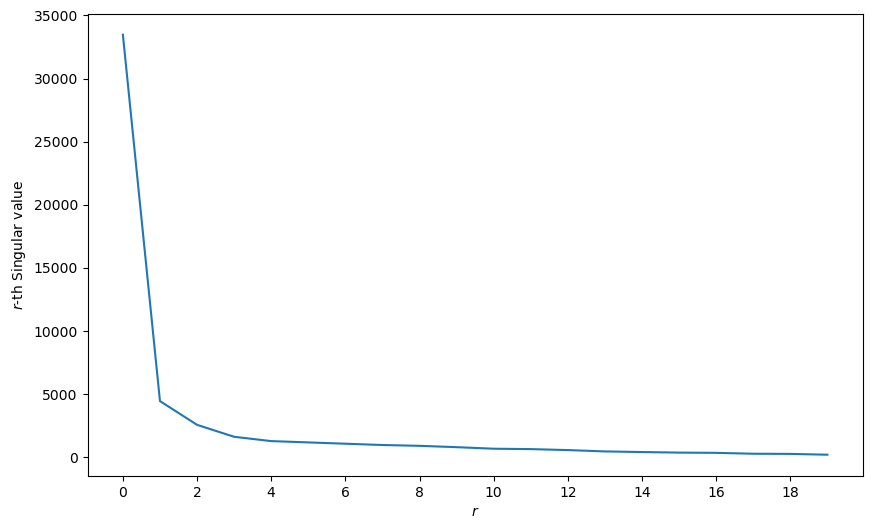

In [21]:
u, s, vh = np.linalg.svd(covid_df.dropna().loc[:, -20:-1].to_numpy())
plt.figure(figsize=(10, 6))
plt.plot(np.power(s, 2))
#plt.semilogy()
plt.xlabel("$r$")
plt.ylabel("$r$-th Singular value")
plt.xticks(np.arange(0, 20, 2))
plt.show()

By analyzing the plot above, we can see that the data appears to have a low rank structure, which justifies the use of the Synthetic Interventions method.

Furthermore, there seems to be an elbow point around 3 or 4 -- either is justifiable in this case because the plot isn't completely clear between the two options.

Then, we stick to $\tilde{r}$ = 4 

In [22]:
Y_pre = severe_countries_ts.loc[:, -20:-1].to_numpy() ## isolating the pre-intervention period

# Applying SVD to denoise the data
u, s, vh = np.linalg.svd(Y_pre)

r_tilde=4
smat = np.zeros((u.shape[0], vh.shape[0])) 
smat[:r_tilde, :r_tilde] = np.diag(s[:r_tilde]) ## creating truncated singular values matrix keeping only the values that preserve 90% of energy

Y_pre_tilde = u @ smat @ vh ## reconstructing the denoised matrix

## **Learn the pre-intervention model**

In [23]:
import statsmodels.api as sm

# The dependent variable here is the pre-intervention time series observations from Brazil
brazil_pre = covid_df[covid_df['country'] == "Brazil"].loc[:, -20: -1].to_numpy().flatten()
dvs = brazil_pre
# We build the model with independent variables from the pre-intervention entries of the denoised matrix
ivs = Y_pre_tilde.T
model = sm.OLS(dvs, ivs)
reg = model.fit()

## **Estimate the post-intervention counterfactual**

In [24]:
Y_post = severe_countries_ts.loc[:, 0:20].to_numpy() ## isolating the post-intervention period
severe_counterfactual_estimates = reg.predict(Y_post.T) ## estimating the severecounterfactual

# get true values for comparison
brazil_post = covid_df[covid_df['country'] == "Brazil"].loc[:, 0: 20].to_numpy().flatten()


## **Plotting the results**

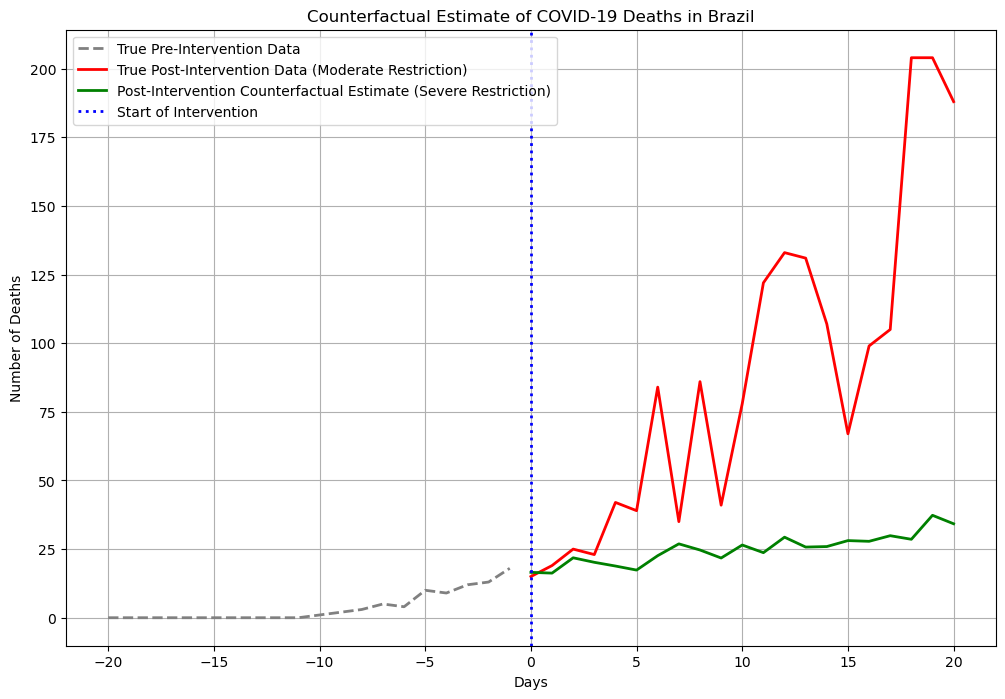

In [25]:
plt.figure(figsize=(12, 8))

plt.plot(range(-20, 0), brazil_pre, 
         label="True Pre-Intervention Data", color='grey', linestyle='--', linewidth=2)

plt.plot(range(0, 21), brazil_post, 
         label="True Post-Intervention Data (Moderate Restriction)", color='red', linestyle='-', linewidth=2)

plt.plot(range(0, 21), severe_counterfactual_estimates, 
         label="Post-Intervention Counterfactual Estimate (Severe Restriction)", color='green', linestyle='-', linewidth=2)

plt.axvline(x=0, color='blue', linestyle=':', linewidth=2, label='Start of Intervention')

plt.xlabel('Days')
plt.ylabel('Number of Deaths')
plt.title('Counterfactual Estimate of COVID-19 Deaths in Brazil')
plt.legend()
plt.grid(True)
plt.show()

## **Conclusions**

   By comparing moderate and severe time series, we find that severe counterfactual has significantly fewer deaths than the true post-intervention data for Brazil (moderate mobility restriction).

   This observation suggests that adopting severe interventions in mobility could have drastically reduced the number of COVID-19-related deaths in countries that were more flexible, such as Brazil.